# Getting started

## Model tuning

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/A-model-tuning"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\A-model-tuning`


> Tuning a single hyperparameter
> 1. Specifying a range of value
> 2. Fitting and inspecting a tuned model

> Tuning nested hyperparameters

### Tuning a single hyperparameter

In MLJ, tuning is implemented as a model wrapper. After wrapping a model in a tuning strategy (e.g. cross-validation) and binding the wrapped model to data in a machine, fitting the machine initiates a search for optimal model hyperparameters.

Let's use a decision tree classifier and tune the maximum depth of the tree. As usual, start by loading data and the model

In [2]:
using MLJ
using PrettyPrinting
X, y = @load_iris
DecisionTreeClassifier = @load DecisionTreeClassifier pkg=DecisionTree

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJDecisionTreeInterface ✔


MLJDecisionTreeInterface.DecisionTreeClassifier

### Specifying a range of value

To specify a range of value, you can use the ```range``` function:

In [3]:
dtc = DecisionTreeClassifier()
r = range(dtc, :max_depth, lower = 1, upper = 5)

NumericRange(1 ≤ max_depth ≤ 5; origin=3.0, unit=2.0)

As you can see, the range function takes a model (```dtc```), a symbol for the hyperparameter of interest (```:max_depth```) and indication of how to samples values. For hyperparameters of type ```<:Real```, you should specify a range of values as done above. For hyperparameters of other type (e.g. ```Symbol```), you should use the ```values=...``` keyword.

Once a range of values has been defined, you can then wrap the model in a ```TunedModel``` specifying the tuning strategy.

In [4]:
tm = TunedModel(model = dtc, ranges = [r, ], measure = cross_entropy)

ProbabilisticTunedModel(
    model = DecisionTreeClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = false,
            merge_purity_threshold = 1.0,
            pdf_smoothing = 0.0,
            display_depth = 5,
            rng = Random._GLOBAL_RNG()),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.7,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = LogLoss(tol = 2.220446049250313e-16),
    weights = nothing,
    operation = nothing,
    range = MLJBase.NumericRange{Int64, MLJBase.Bounded, Symbol}[NumericRange(1 ≤ max_depth ≤ 5; origin=3.0, unit=2.0)],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats =

Note that "wrapping a model in a tuning strategy" as above means creating a new "self-tuning" version of the model, ```tuned_model = TunedModel(model=...)```, in which further key-word arguments specify:

1. the algorithm (a.k.a., tuning strategy) for searching the hyper-parameter space of the model (e.g., ```tuning = Random(rng=123)``` or ```tuning = Grid(goal=100)```).

2. the resampling strategy, used to evaluate performance for each value of the hyper-parameters (e.g., ```resampling=CV(nfolds=9, rng=123)``` or ```resampling=Holdout(fraction_train=0.7)```).

3. the measure (or measures) on which to base performance evaluations (and for reporting purposes) (e.g., ```measure = rms``` or ```measures = [rms, mae]```).

4. the range, usually describing the "space" of hyperparameters to be searched (but more generally whatever extra information is required to complete the search specification, e.g., initial values in gradient-descent optimization).

For more options do ```?TunedModel```.

### Fitting and inspecting a tuned model

To fit a tuned model, you can use the usual syntax:

In [5]:
m = machine(tm, X, y)

Machine{ProbabilisticTunedModel{Grid,…},…} trained 0 times; caches data
  model: MLJTuning.ProbabilisticTunedModel{Grid, MLJDecisionTreeInterface.DecisionTreeClassifier}
  args: 
    1:	Source @166 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @953 ⏎ `AbstractVector{Multiclass{3}}`


In [6]:
fit!(m)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 5 metamodels: 100%[=========================] Time: 0:00:06


Machine{ProbabilisticTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.ProbabilisticTunedModel{Grid, MLJDecisionTreeInterface.DecisionTreeClassifier}
  args: 
    1:	Source @166 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @953 ⏎ `AbstractVector{Multiclass{3}}`


In order to inspect the best model, you can use the function ```fitted_params``` on the machine and inspect the ```best_model``` field:

In [7]:
fitted_params(m).best_model

DecisionTreeClassifier(
    max_depth = 1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5,
    rng = Random._GLOBAL_RNG())

In [8]:
fitted_params(m).best_model.max_depth

1

Note that here we have tuned a probabilistic model and consequently used a probabilistic measure for the tuning. We could also have decided we only cared about the mode and the misclassification rate, to do this, just use ```operation=predict_mode``` in the tuned model:

In [9]:
tm = TunedModel(model = dtc,
                ranges = r, 
                operation = predict_mode, 
                measure = misclassification_rate)
m = machine(tm, X, y)
fit!(m)
fitted_params(m).best_model

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 5 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 5 metamodels: 100%[=========================] Time: 0:00:00


DecisionTreeClassifier(
    max_depth = 2,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5,
    rng = Random._GLOBAL_RNG())

In [10]:
fitted_params(m).best_model.max_depth

2

In [11]:
r = report(m)

(best_model = DecisionTreeClassifier,
 best_history_entry = (model = DecisionTreeClassifier,
                       measure = [MisclassificationRate()],
                       measurement = [0.1111111111111111],
                       per_fold = [[0.1111111111111111]],),
 history = NamedTuple{(:model, :measure, :measurement, :per_fold), Tuple{MLJDecisionTreeInterface.DecisionTreeClassifier, Vector{MisclassificationRate}, Vector{Float64}, Vector{Vector{Float64}}}}[(model = DecisionTreeClassifier, measure = [MisclassificationRate()], measurement = [0.1111111111111111], per_fold = [[0.1111111111111111]]), (model = DecisionTreeClassifier, measure = [MisclassificationRate()], measurement = [0.2222222222222222], per_fold = [[0.2222222222222222]]), (model = DecisionTreeClassifier, measure = [MisclassificationRate()], measurement = [0.26666666666666666], per_fold = [[0.26666666666666666]]), (model = DecisionTreeClassifier, measure = [MisclassificationRate()], measurement = [1.0], per_fold = [[

In [12]:
r.best_history_entry.measurement[1]

0.1111111111111111

Anyone wants plots? of course:

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


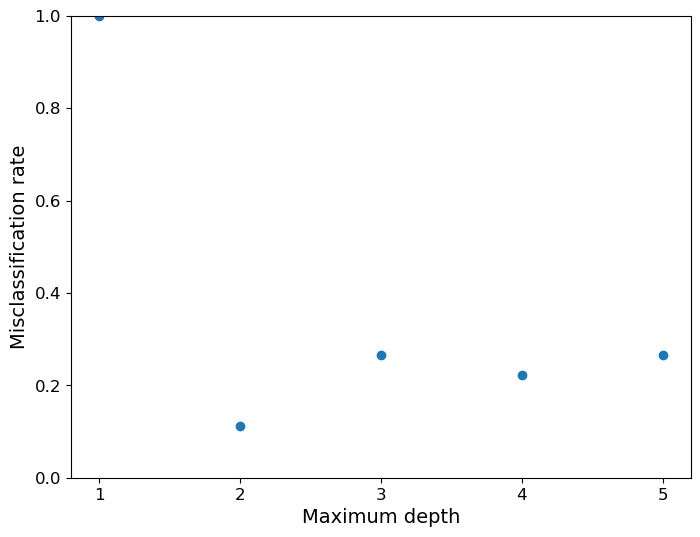

In [13]:
using PyPlot
figure(figsize = (8, 6))
res = r.plotting  # contains all you need for plotting
plot(res.parameter_values, res.measurements, ls = "none", marker = "o")

xticks(1:5, fontsize = 12)
yticks(fontsize = 12)
xlabel("Maximum depth", fontsize = 14)
ylabel("Misclassification rate", fontsize = 14)
ylim([0, 1])
savefig("./plots/2.3.1.png")

### Tuning nested hyperparameters

Let's generate simple dummy regression data

In [14]:
X = (x1 = rand(100), x2 = rand(100), x3 = rand(100))
y = 2X.x1 - X.x2 + 0.05*randn(100);

Let's then build a simple ensemble model with decision tree regressors:

In [15]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree
forest = EnsembleModel(model = DecisionTreeRegressor())

import MLJDecisionTreeInterface

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


 ✔


DeterministicEnsembleModel(
    model = DecisionTreeRegressor(
            max_depth = -1,
            min_samples_leaf = 5,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = false,
            merge_purity_threshold = 1.0,
            rng = Random._GLOBAL_RNG()),
    atomic_weights = Float64[],
    bagging_fraction = 0.8,
    rng = Random._GLOBAL_RNG(),
    n = 100,
    acceleration = CPU1{Nothing}(nothing),
    out_of_bag_measure = Any[])

Such a model has nested hyperparameters in that the ensemble has hyperparameters (e.g. the ```:bagging_fraction```) and the atom has hyperparameters (e.g. ```:n_subfeatures``` or ```:max_depth```). You can see this by inspecting the parameters using ```params```:

In [16]:
params(forest) |> pprint

(model = (max_depth = -1,
          min_samples_leaf = 5,
          min_samples_split = 2,
          min_purity_increase = 0.0,
          n_subfeatures = 0,
          post_prune = false,
          merge_purity_threshold = 1.0,
          rng = Random._GLOBAL_RNG()),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 100,
 acceleration = CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

Range for nested hyperparameters are specified using dot syntax, the rest is done in much the same way as before:

In [17]:
r1 = range(forest, :(model.n_subfeatures), lower = 1, upper = 3)
r2 = range(forest, :bagging_fraction, lower = 0.4, upper = 1.0)
tm = TunedModel(model = forest, 
                tuning = Grid(resolution = 12),
                resampling = CV(nfolds = 6),
                ranges = [r1, r2],
                measure = rms)

DeterministicTunedModel(
    model = DeterministicEnsembleModel(
            model = DecisionTreeRegressor,
            atomic_weights = Float64[],
            bagging_fraction = 0.8,
            rng = Random._GLOBAL_RNG(),
            n = 100,
            acceleration = CPU1{Nothing}(nothing),
            out_of_bag_measure = Any[]),
    tuning = Grid(
            goal = nothing,
            resolution = 12,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = RootMeanSquaredError(),
    weights = nothing,
    operation = nothing,
    range = MLJBase.NumericRange{T, MLJBase.Bounded, Symbol} where T[NumericRange(1 ≤ model.n_subfeatures ≤ 3; origin=2.0, unit=1.0), NumericRange(0.4 ≤ bagging_fraction ≤ 1.0; origin=0.7, unit=0.3)],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = nothing

In [18]:
m = machine(tm, X, y)

Machine{DeterministicTunedModel{Grid,…},…} trained 0 times; caches data
  model: MLJTuning.DeterministicTunedModel{Grid, MLJEnsembles.DeterministicEnsembleModel{MLJDecisionTreeInterface.DecisionTreeRegressor}}
  args: 
    1:	Source @541 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @771 ⏎ `AbstractVector{Continuous}`


In [19]:
fit!(m)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 36 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 36 metamodels: 100%[=========================] Time: 0:00:03


Machine{DeterministicTunedModel{Grid,…},…} trained 1 time; caches data
  model: MLJTuning.DeterministicTunedModel{Grid, MLJEnsembles.DeterministicEnsembleModel{MLJDecisionTreeInterface.DecisionTreeRegressor}}
  args: 
    1:	Source @541 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @771 ⏎ `AbstractVector{Continuous}`


A useful function to inspect a model after fitting it is the ```report``` function which collects information on the model and the tuning, for instance you can use it to recover the best measurement:

In [20]:
r = report(m);
r.best_history_entry.measurement[1]

0.1868492251495128

In [21]:
r.plotting.parameter_values[:,1]

36-element Vector{Any}:
 2
 3
 1
 2
 1
 3
 3
 3
 2
 1
 1
 2
 1
 ⋮
 3
 1
 2
 1
 3
 1
 2
 3
 1
 2
 3
 2

Let's visualise this

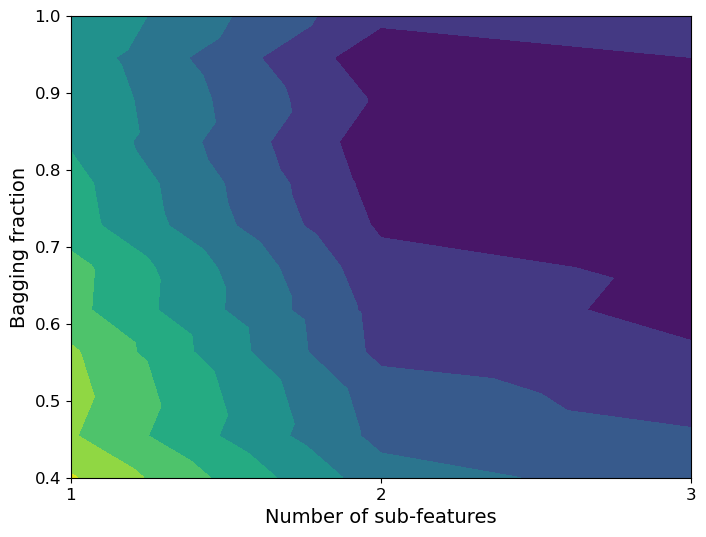

In [22]:
figure(figsize=(8,6))

res = r.plotting

vals_sf = res.parameter_values[:, 1]
vals_bf = res.parameter_values[:, 2]

tricontourf(vals_sf, vals_bf, res.measurements)
xlabel("Number of sub-features", fontsize=14)
ylabel("Bagging fraction", fontsize=14)
xticks([1, 2, 3], fontsize=12)
yticks(fontsize=12)
savefig("./plots/2.3.2.png")

In [24]:
res.measurements * 10

36-element Vector{Float64}:
 1.8797008359892016
 2.2228104525543797
 3.2706935418519127
 1.8721914949685856
 2.7232066167348012
 1.868492251495128
 1.9568501986121878
 1.9347908883935607
 2.299877631892534
 3.22052997122921
 2.892601045225227
 2.049730977629894
 3.072117731428052
 ⋮
 1.9313215020372108
 2.779908081460941
 1.9711048020557698
 3.42104486013987
 2.023967681949732
 2.762290519406064
 2.4862538565205154
 1.8884985725713577
 3.062971818557498
 1.9658500850086016
 1.8897342542769282
 2.340497302601842

In [52]:
res.parameter_values[10, :]

2-element Vector{Any}:
 1
 0.45454545454545453

In [53]:
res.measurements[10]

0.322052997122921

In [47]:
res.parameter_values[7, :]

2-element Vector{Any}:
 3
 0.6727272727272727

In [48]:
res.measurements[7]

0.19568501986121878